# Colisiones 2D

Este programa esta implementado para simular la interacción que se presenta entre particulas solidas contenidas en un espacio finito

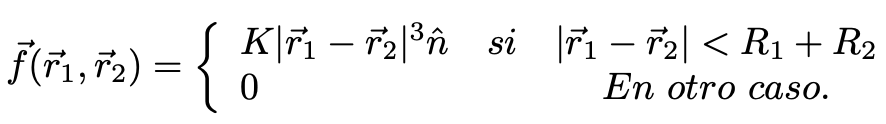

Para este modelo de interacción entre las esferas, la constante K indica el coeficiente de deformación carácteristico de cada uno de los objetos interactuantes. El significado fisico de este coeficiente es la resistencia que opone el material del que se encuentra desarrollada la bola de billar para deformar su estructura tridimensional. Esto quiere decir que para un coeficiente mayor, se requiere una mayor fuerza para modificar la forma del volúmen de la esfera.

# Conservación de energía

Cuando hay una fuerza que es conservativa, hay una cantidad que se esta conservado, en este caso la energía del sistema, esto lleva que la energía mecanica en cualquier punto tempoeral tenga el mismo valor. 

Importamos las librerias que vamos a utilizar para poder llevar a cabo la animación

In [1]:
%matplotlib notebook 
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
import matplotlib.animation as anim

Definimos la clase que se encarga de asignar los atributos y definir los metodos a partir de los cuales se va a resolver el problema de interacción entre las particulas

In [3]:
class Particle():
    
    # init
    def __init__(self, r0,v0,a0,t,m,radius,Id):
        self.dt  = t[1] - t[0]
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.rVector = np.zeros( (len(t),len(r0)) )
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
    # Method
    def Evolution(self,i): 
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        self.SetAceleration(i,self.a)
    
        # Euler method
        self.r += self.dt * self.v
        self.v += self.dt * self.a
            
    def CheckWallLimits(self,limits,dim=2):
        for i in range(dim):
            if self.r[i] + self.radius > limits[i]:
                self.v[i] = - self.v[i]
            if self.r[i] - self.radius < - limits[i]:
                self.v[i] = - self.v[i]
                
    def ReduceSizevelocity(self,factor):
        self.RvVector = np.array([self.vVector[0]]) # initial condition
        for i in range(1,len(self.vVector)):
            if i%factor == 0:
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])
        
    def ReduceSize(self,factor):
        self.RrVector = np.array([self.rVector[0]]) # initial condition
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                
     
    def interactions(self,particle, k = 100):
        condicion = np.linalg.norm(self.r - particle.r)
        condicion2 = self.radius + particle.radius
        if condicion < condicion2:
            self.a = (k*(condicion**3)*((self.r - particle.r)/(self.radius+particle.radius))/self.m)

            
    def energia_del_sistema_k(self, particulas):
        Ek = 0
        for particula in particulas:
            Eo=(1/2)*particula.m*(la.norm(particula.v))**2
            Ek= Eo + Ek
        return Ek
    
    def energia_del_sistema_U(self, particulas, Em=200):
        Eu= Em-  self.energia_del_sistema_k(particulas)
        
        return Eu
    
    # Setters
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v
    def SetAceleration(self, i, a):
        self.aVector[i] = a
        
    # Getters  
    def GetPositionVector(self):
        return self.rVector

    def GetRPositionVector(self):
        return self.RrVector
    
    def GetVelocityVector(self):
        return self.vVector
    
    def GetRVelocityVector(self):
        return self.RvVector
    
    def GetR(self):
        return self.radius
    
    def GetAcelerationVector(self):
        return self.aVector

Definimos una función que se encarga de generar las particulas que vamos a simular

In [4]:
def GetindividualParticle(position, velocity, aceleration, t):

    x0 = position
    v0 = velocity
    a0 = aceleration
        
    p = Particle(x0,v0,a0,t,1.,2.0,1)
        
    return p

In [5]:
#Discretización del tiempo 

dt = 0.0001
tmax = 10
tiempo = np.arange(0,tmax+dt,dt)

In [6]:
esferas_solidas = []
posiciones_iniciales = np.array([[-8,1.6], [0.,-1.6], [-15., -15.]])
velocidades_iniciales = np.array([[20.,0.], [0.,0.], [0.,0.]])
aceleraciones_iniciales = np.array([[0.,0.],[0.,0.],[0.,0.]])
Esk=np.zeros(len(tiempo))
EsU=np.zeros(len(tiempo))

for i in range(len(posiciones_iniciales)):
    particle = GetindividualParticle(posiciones_iniciales[i], velocidades_iniciales[i], aceleraciones_iniciales[i], tiempo)
    esferas_solidas.append(particle)
print(esferas_solidas)

[<__main__.Particle object at 0x000001DCEDC70388>, <__main__.Particle object at 0x000001DCFDE6A8C8>, <__main__.Particle object at 0x000001DCFDE6AD48>]


In [7]:
def RunSimulationP(t,P, Limits):
    for it in tqdm(range(len(t))): # Evolucion temporal
        for interes in range(len(P)):
            for interaccion in range(len(P)):
                if interes != interaccion:
                    P[interes].interactions(P[interaccion])
            P[interes].CheckWallLimits(Limits)
            P[interes].Evolution(it)
            P[interes].a = 0
        Eki=P[0].energia_del_sistema_k(P)
        EUi=P[0].energia_del_sistema_U(P)
        Esk[it]=Eki
        EsU[it]=EUi
    return P

In [8]:
Limits = np.array([20.,20.])

In [9]:
esferas_solidas = RunSimulationP(tiempo,esferas_solidas, Limits)

100%|██████████████████████████████████████████████████████████████████████████| 100001/100001 [00:32<00:00, 3076.74it/s]


In [10]:
def ReduceTimeP(t,factor):
    
    for P in esferas_solidas:
        P.ReduceSize(factor)
        P.ReduceSizevelocity(factor)
        
    Newt = []
    
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])        
    return np.array(Newt)

In [11]:
redt = ReduceTimeP(tiempo,1000)

<IPython.core.display.Javascript object>


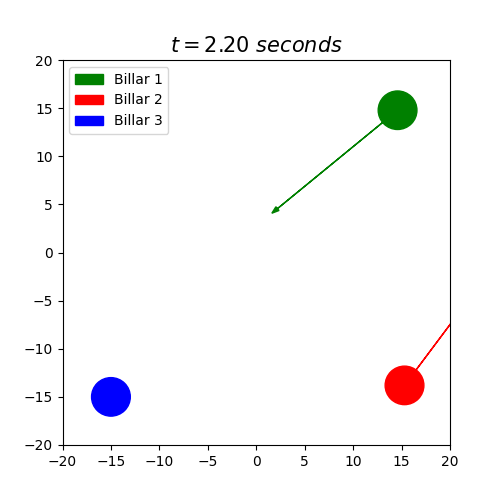

In [13]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)


def init():
    ax.set_xlim(-Limits[0],Limits[0])
    ax.set_ylim(-Limits[1],Limits[1])

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15)

    x1 = esferas_solidas[0].GetRPositionVector()[i,0]
    y1 = esferas_solidas[0].GetRPositionVector()[i,1]
    x2 = esferas_solidas[1].GetRPositionVector()[i,0]
    y2 = esferas_solidas[1].GetRPositionVector()[i,1]
    x3 = esferas_solidas[2].GetRPositionVector()[i,0]
    y3 = esferas_solidas[2].GetRPositionVector()[i,1]  
        
    vx1 = esferas_solidas[0].GetRVelocityVector()[i,0]
    vy1 = esferas_solidas[0].GetRVelocityVector()[i,1]
    vx2 = esferas_solidas[1].GetRVelocityVector()[i,0]
    vy2 = esferas_solidas[1].GetRVelocityVector()[i,1]
    vx3 = esferas_solidas[2].GetRVelocityVector()[i,0]
    vy3 = esferas_solidas[2].GetRVelocityVector()[i,1]
    
    circle1 = plt.Circle((x1,y1), esferas_solidas[0].GetR(), color='green', fill=True )
    plot = ax.add_patch(circle1)
    circle2 = plt.Circle((x2,y2), esferas_solidas[1].GetR(), color='red', fill=True )
    plot = ax.add_patch(circle2)
    circle3 = plt.Circle((x3,y3), esferas_solidas[2].GetR(), color='blue', fill=True )
    plot = ax.add_patch(circle3)
    
    plot = ax.arrow(x1,y1,vx1,vy1,color='green',head_width=0.5, label = "Billar 1")
    plot = ax.arrow(x2,y2,vx2,vy2,color='red',head_width=0.5, label = "Billar 2")
    plot = ax.arrow(x3,y3,vx3,vy3,color='blue',head_width=0.5, label = "Billar 3")
    ax.legend()

    return plot

Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)


<IPython.core.display.Javascript object>


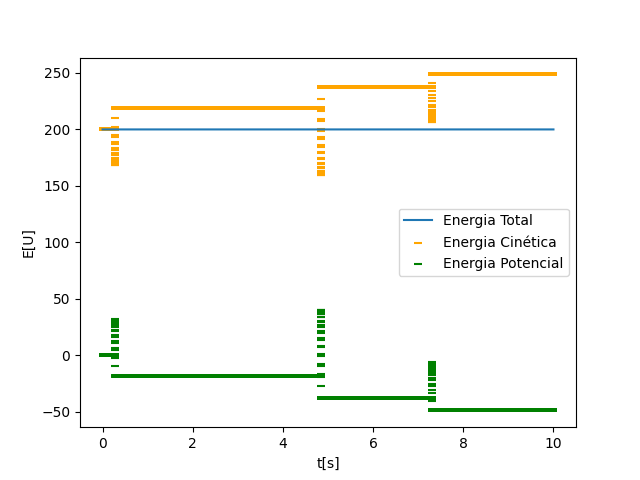

Text(0, 0.5, 'E[U]')

In [16]:
plt.scatter(tiempo, Esk,  marker="_", label="Energia Cinética", color="orange")
plt.scatter(tiempo, EsU, marker="_", label="Energia Potencial", color="green")
plt.plot(tiempo, Esk+EsU, label="Energia Total")
plt.legend()
plt.xlabel("t[s]")
plt.ylabel("E[U]")